In [2]:
import boto3
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from PIL import Image
import statsmodels.api as sm
from scipy import stats

# this is using login to the API via OAuth which enables private data for your own channel

credentials = None

# token.pickle stores the user's credentials from previously successful logins
if os.path.exists('token.pickle'):
    print('Loading credentials from file...')
    with open('token.pickle', 'rb') as token:
        credentials = pickle.load(token)

if not credentials or not credentials.valid:
    if credentials and credentials.expired and credentials.refresh_token:
        print('Refreshing Access Token...')
        credentials.refresh(Request())
    else:
        print('Fetching new tokens...')
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secrets.json',
            scopes=[
                'https://www.googleapis.com/auth/youtube.readonly',
                'https://www.googleapis.com/auth/yt-analytics.readonly'
                ]
            )
        
        flow.run_local_server(port=8080,prompt='consent')
        # you receive access and refresh tokens
        # refresh token is to get new acccess tokens
        credentials = flow.credentials

        #save
        with open('token.pickle'', ''wb') as f:
            print('Saving credentials for future use...')
            pickle.dump(credentials, f)

# Create YouTube API object
youtubeReporting = build('youtubereporting', 'v1', credentials=credentials)

Loading credentials from file...
Refreshing Access Token...


In [1]:
import boto3
import pandas as pd

def download_dynamodb_table(table_name):
    dynamodb = boto3.resource('dynamodb')
    table = dynamodb.Table(table_name)

    # Scan the entire DynamoDB table
    response = table.scan()

    # Extract items from the response
    items = response['Items']

    # Continue scanning if the table has more items
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        items.extend(response['Items'])

    return items

def dynamodb_to_dataframe(items):
    df = pd.DataFrame(items)
    return df

In [4]:
# Example usage
table_name = 'channel_basic_a2'
items = download_dynamodb_table(table_name)
df = dynamodb_to_dataframe(items)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   annotation_clickable_impressions  203 non-null    object
 1   card_teaser_clicks                203 non-null    object
 2   videos_removed_from_playlists     203 non-null    object
 3   likes                             203 non-null    object
 4   watch_time_minutes                203 non-null    object
 5   video_id                          203 non-null    object
 6   subscribed_status                 203 non-null    object
 7   subscribers_lost                  203 non-null    object
 8   composite_key                     203 non-null    object
 9   annotation_close_rate             203 non-null    object
 10  red_views                         203 non-null    object
 11  subscribers_gained                203 non-null    object
 12  card_teaser_impression

In [21]:
dimensions = ['date', 'channel_id', 'video_id', 'live_or_on_demand', 'subscribed_status', 'country_code']

int_metrics = ['views', 'comments', 'likes', 'dislikes', 'videos_added_to_playlists', 'videos_removed_from_playlists', 
           'shares', 'annotation_impressions', 
           'annotation_clickable_impressions', 'annotation_closable_impressions', 'annotation_clicks', 
           'annotation_closes', 'card_impressions', 'card_teaser_impressions', 
           'card_clicks', 'card_teaser_clicks', 'subscribers_gained', 'subscribers_lost', 'red_views']

float_metrics = ['watch_time_minutes', 'average_view_duration_seconds', 'average_view_duration_percentage', 
           'annotation_click_through_rate', 'annotation_close_rate', 
           'card_click_rate', 'card_teaser_click_rate', 'red_watch_time_minutes']

In [7]:
df = df.drop(columns='composite_key')

In [10]:
for metric in int_metrics:
    df[metric] = df[metric].apply(int)

In [11]:
for metric in float_metrics:
    df[metric] = df[metric].apply(float)

In [19]:
# Convert 'date' column to date format
df['date'] = pd.to_datetime(df['date']).dt.date

# Convert 'createTime' column to datetime format
df['createTime'] = pd.to_datetime(df['createTime'])

In [30]:
# Sort DataFrame by 'dimensions', 'date', and 'createTime' in descending order
df.sort_values(by=['date', 'channel_id', 'video_id', 'live_or_on_demand', 'subscribed_status', 'country_code', 'createTime'], 
               ascending=[True, True, True, True, True, True, False], inplace=True)

# Drop duplicates based on 'composite_key' and 'date', keeping only the first row for each unique combination
cleaned_df = df.drop_duplicates(subset=['date', 'channel_id', 'video_id', 'live_or_on_demand', 
                                        'subscribed_status', 'country_code'], keep='first')

In [34]:
cleaned_df.shape

(193, 34)

In [43]:
# let's use only the videos that were not new, but were those where I changed titles, descriptions and thumbnails

old_videos = ['4UYevtuy5Dg', 'RNPu4vywWtQ','PnuKrfa1WXQ','5sDNYWaH_j0','JqDFkySxqJw','BBFpTBdLstc','PBPtfJZV0zU','kBDAXVUbSRQ',
'Y2yMeeT_lGQ','FVIQas0WJ4s','2DaIjqiv5_E','zU26N0eHZHo','ES4m8mIANI0','xZLzIolu2R0','HBN41CdWIAE','IJCq-83k3zs',
'cUHrTkaDi5g','mOJlyDBsjyk','KO_N4XkvEgA','qcNssx6gKpw','pLcLqx32tV0','EX8UjdeIfss','IaM5yeSlfMM','0Uck3DZIRso',
'TWF9bikd00I','E7Ie93oR2HU','prpbXRIaOaY','hxdoSA7vafg','rqOwQuLhU_Q','bWhN5ufX0Ac','BzI7WOGNQyc','jL9XJAFUZYc',
'dgqqKcy_2DY','FRQ6VwpJKoc','mT3F8_R7_aM','lK0pUV7xSVY','ODDtQ_1Wamo','V36c07F_k5I','HJMbT0be98o','Kt6uK-y32ps',
'KTUm6Q63sJw','BBA1-apEp4Y','hiHdhN1OMR8','QKu05E5mIQA','GNahA3H-oX0'
]

old_df = cleaned_df[cleaned_df['video_id'].isin(old_videos)]

In [46]:
grouped_views = old_df.groupby(['date'])[['views', 'likes', 'annotation_clickable_impressions']].sum()

In [47]:
grouped_views

,views,likes,annotation_clickable_impressions
date,,,
2024-02-21,4,0,0
2024-02-22,3,0,0
2024-02-23,4,0,0
2024-02-24,2,0,0
2024-02-25,1,0,0
2024-02-26,4,0,0
2024-02-27,1,0,0
2024-02-28,1,0,0
2024-03-04,1,0,0


c:\Projekte\Youtube_Analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Projekte\Youtube_Analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Projekte\Youtube_Analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Projekte\Youtube_Analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

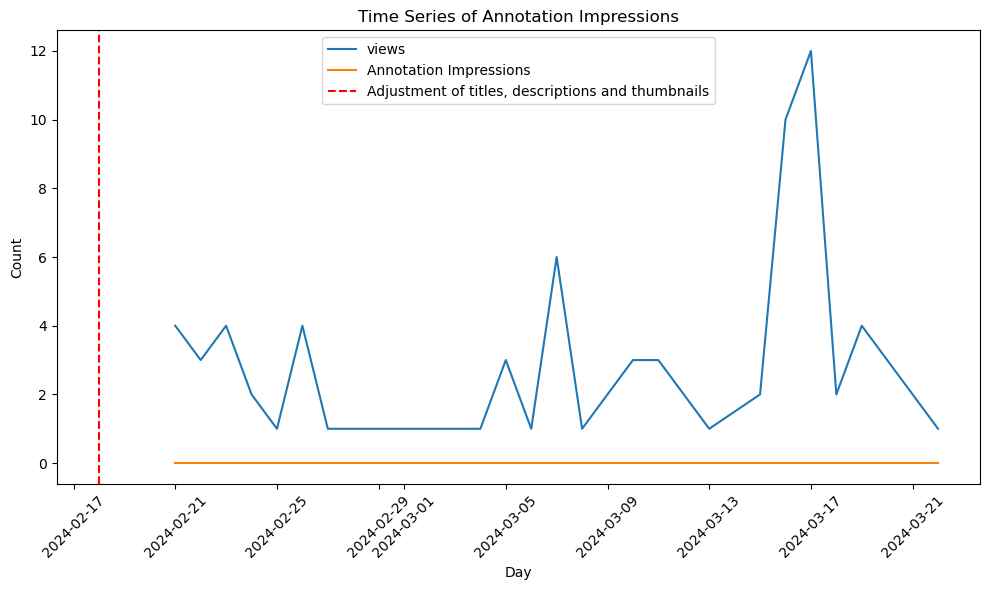

In [50]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_views, x='date', y='views',
             label='views')
sns.lineplot(data=grouped_views, x='date', y='annotation_clickable_impressions',
             label='Annotation Impressions')

# Add a vertical line at 2024-02-18
plt.axvline(x=datetime(2024,2,18), color='red', linestyle='--', label='Adjustment of titles, descriptions and thumbnails')

# Set labels and title
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Time Series of Annotation Impressions')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Show plot
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()
